In [1]:
"""
auteur:Alexandre
date:2024/09/06

Ajout d'un clampage sur les nuances n'ayants pas obtenues plus de 12.5% des suffrages
"""

"\nauteur:Alexandre\ndate:2024/09/06\n\nAjout d'un clampage sur les nuances n'ayants pas obtenues plus de 12.5% des suffrages\n"

# **Modèle de Transfert de Voix**

## Chargement des données

In [2]:
import fitting_model as ft
import pandas as pd
import params as prm
import numpy as np
import os

In [3]:
df_1f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_1er_tour}.csv"))
df_2f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_2nd_tour}.csv"))
print(df_1f.shape, df_2f.shape)

(61593, 23) (61593, 18)


## Définition du modèle

In [4]:
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [13]:
class TransfertVoix(torch.nn.Module):
    def __init__(self, N_1er, N_2eme):#, device=None):
        super(TransfertVoix, self).__init__()
        
        self.lin = torch.nn.Linear(N_2eme, N_1er, bias=False)

    def forward(self, p_1):
        
        # p_1_calmped = p_1 * (p_1 > 0.125) # Ajout d'un clampage # Ancien TODO à changer

        bv, nu_1 = torch.where(p_1.cpu().detach().numpy() > 0.125) # Localisation des bv et nuances n'ayant pas obtenue plus de 12.5%
        
        nu_2 = [] # Conversion entre les indexs des nuances du 1er et du second tour
        for n in nu_1 :
            nu_2.append(prm.conversion_nuance_dico[n])
        nu_2 = np.array(nu_2)
        
        here_2nd = np.where(nu_2 != None)[0] # On retire les groupes n'ayant pas trouver équivalent au second tour
        p_1_clamped = p_1
        p_1_clamped[bv[here_2nd],nu_2[here_2nd].astype(int)] = 0 # Clampage des nuances quand elles ont moins que 12.5 à leur bv
        
        M = torch.softmax(self.lin.weight, axis=1)
        p_2_pred = torch.matmul(torch.Tensor(p_1_clamped), M)
        
        return p_2_pred

In [14]:
def pdf_loss(p_pred, p, weight):

    ind_nonzero = (p==0) + (p_pred==0)
    p[ind_nonzero] = 1.
    p_pred[ind_nonzero] = 1.
    kl_div = p * (p.log() - p_pred.log())
    loss_train = (kl_div * weight[:, None]).sum()
    
    return loss_train

In [15]:
def fit_data(
    df_1f,
    df_2f,
    
    lr=1e-5,
    batch_size=2**5,
    num_epochs=500,
    
    seed=2024,
    device=None
):
    
    # Paramètrage des calculs
    if device == "cpu":
        print(f"Il semble y avoir {os.cpu_count()} coeurs dans cet ordi !")
    elif device == "cuda":
        if torch.cuda.is_available() == True:
            print("GPU ! GPU ! GPU !")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda": torch.cuda.empty_cache()

    # Preparation des données
    pre_X_train, pre_X_test, pre_Y_train, pre_Y_test = train_test_split(
        df_1f, df_2f, 
        test_size=.2, 
        random_state=seed, 
        shuffle=True
    )
    X_train, X_test = pre_X_train[pre_X_train.keys()[:-1]], pre_X_test[pre_X_test.keys()[:-1]]
    Y_train, Y_test = pre_Y_train[pre_Y_train.keys()[:-1]], pre_Y_test[pre_Y_test.keys()[:-1]]

    loader = DataLoader(
                    TensorDataset(
                        torch.Tensor(X_train.to_numpy()).to(device), 
                        torch.Tensor(Y_train.to_numpy()).to(device)
                    ), batch_size=batch_size, shuffle=True
                )
    
    # Préparation du modèle
    N_1er, N_2eme = X_train.shape[-1], Y_train.shape[-1]
    trans = TransfertVoix(N_1er, N_2eme)
    trans = trans.to(device)

    # Préparation de l'apprentissage
    optimizer = torch.optim.Adam(
        trans.parameters(), 
        lr=lr
    )

    losses_train = []
    losses_test = []

    for epoch in tqdm(range(int(num_epochs)), desc=f"Computing on {device}"):
        
        for p_1, p_2 in loader:

            p_1, p_2 = p_1.to(device), p_2.to(device)
            sum_1, sum_2 = p_1.sum(axis=1)[:,None], p_2.sum(axis=1)[:,None]

            p_1t = p_1 / sum_1
            p_2t = p_2 / sum_2
            
            p_2_pred = trans(p_1t)
            
            weight = sum_2 / sum_2.sum()

            loss_train = pdf_loss(p_2_pred, p_2t, weight)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        losses_train.append(loss_train.item())

        with torch.no_grad():
            
            x_test = torch.Tensor(X_test.to_numpy()).to(device)
            sum_test_1 = x_test.cpu().sum(axis=-1)[:,None].to(device)
            sum_test_1[np.where(sum_test_1.cpu() == 0)] = 1

            y_test = torch.Tensor(Y_test.to_numpy()).to(device)
            sum_test_2 = y_test.cpu().sum(axis=-1)[:,None].to(device)
            sum_test_2[np.where(sum_test_2.cpu() == 0)] = 1

            Y_pred = trans(x_test / sum_test_1)
            
            weight = sum_test_2 / sum_test_2.sum()

            losse_test = pdf_loss(Y_pred, y_test / sum_test_2, weight)
            losses_test.append(losse_test.item())

    return trans, np.array(losses_train), np.array(losses_test), Y_pred.cpu().detach().numpy(), (y_test / sum_test_2).cpu().detach().numpy()

## Entrainement du modèle

In [31]:
batch_size = 2**5
num_epochs = 300
lr = 1e-5

In [32]:
trans, losses_train, losses_test, pred, test = ft.fit_data(
    df_1f=df_1f,
    df_2f=df_2f,
    batch_size=batch_size,
    num_epochs=num_epochs,
    device="cpu",
    lr=lr
)

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu: 100%|██████████| 300/300 [12:32<00:00,  2.51s/it]


In [33]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"D1_model_clamped_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), pred)
np.save(os.path.join(result_path, "test"), test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epochs = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

## Représentation des résultats

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

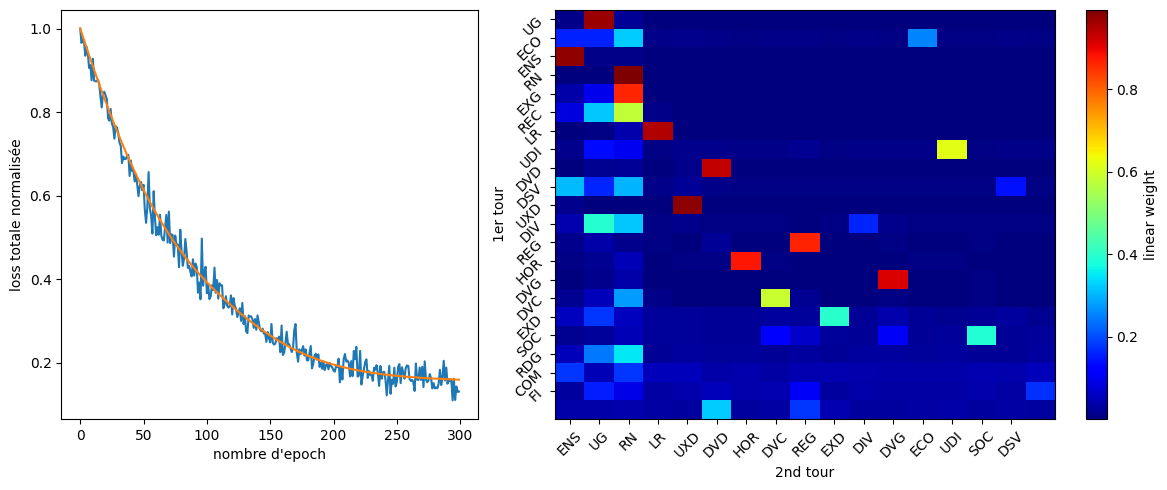

In [35]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12,5),
    gridspec_kw={"width_ratios":[0.4,0.6]},
    dpi=100
)

ax[0].plot(
    range(num_epochs),
    losses_train / losses_train.max()
)
ax[0].plot(
    range(num_epochs),
    losses_test / losses_test.max()
)
ax[0].set_xlabel("nombre d'epoch")
ax[0].set_ylabel("loss totale normalisée")

m1 = ax[1].imshow(
    # trans.lin.weight.cpu().detach().numpy(),
    torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy(),
    cmap="jet", aspect="auto",
    # vmin=-6, vmax=+6
)
cbar = fig.colorbar(m1, ax=ax[1])
cbar.set_label("linear weight")
ax[1].set_xticks(
    range(df_2f.keys()[:-2].shape[-1]),
    df_2f.keys()[:-2],
    rotation=45
)
ax[1].set_yticks(
    range(df_1f.keys()[:-2].shape[-1]),
    df_1f.keys()[:-2],
    rotation=45
)
ax[1].set_xlabel("2nd tour")
ax[1].set_ylabel("1er tour")

plt.tight_layout()
plt.show()

In [36]:
report_norm = torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy() / torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy().sum(axis=0)
cmap = prm.cm.tab20

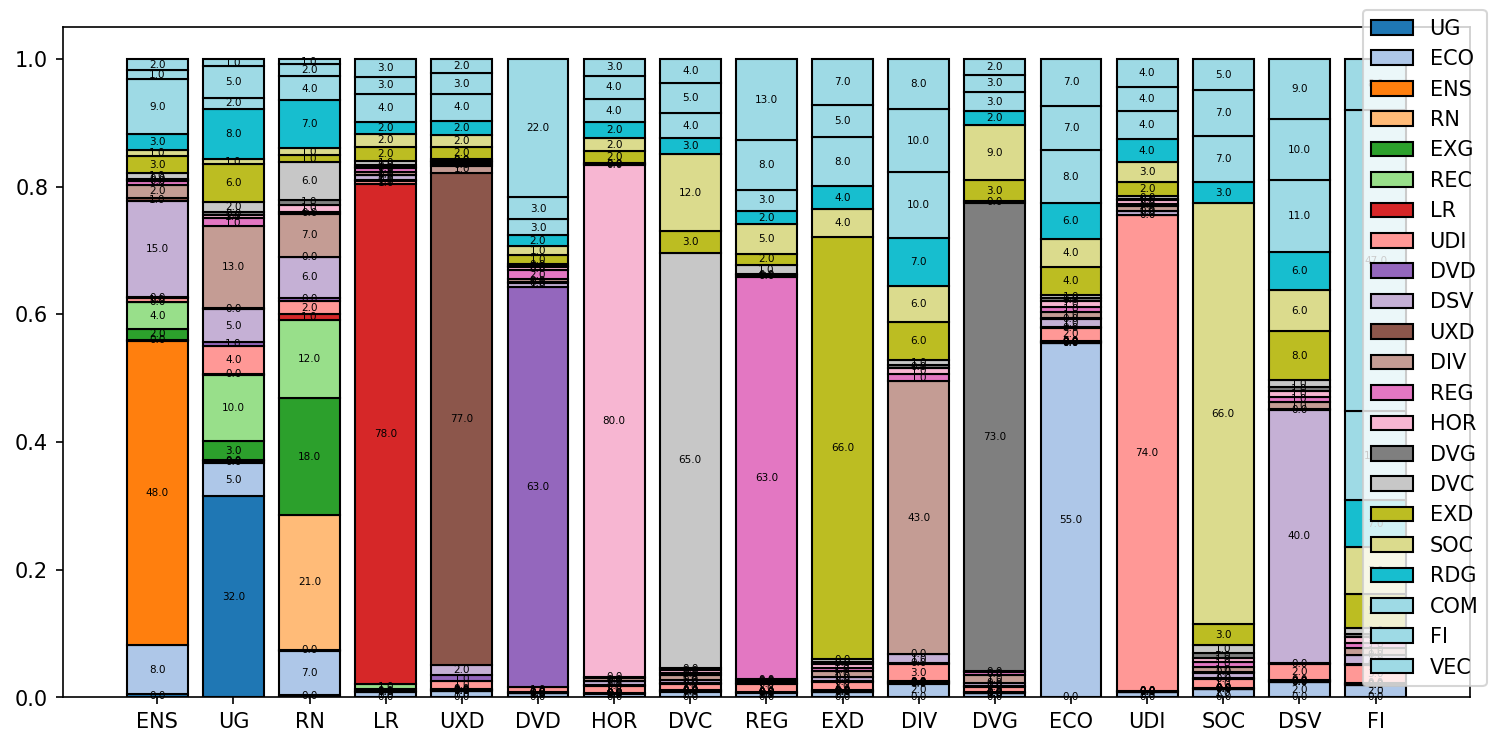

In [37]:
fig,ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10,5),
    dpi=150
)

for i in range(df_1f.shape[-1]-1):
    
    b = ax.bar(
        df_2f.keys()[:-1],
        height=report_norm[i,:],
        bottom=report_norm[:i,:].sum(axis=0),
        label=df_1f.keys()[i],
        color=cmap(i),
        edgecolor="black",
        linewidth=1
    )
    ax.bar_label(
        b,
        np.round(report_norm[i,:]*100),
        label_type="center",
        size=5
    )

fig.legend()
plt.tight_layout()
plt.show()

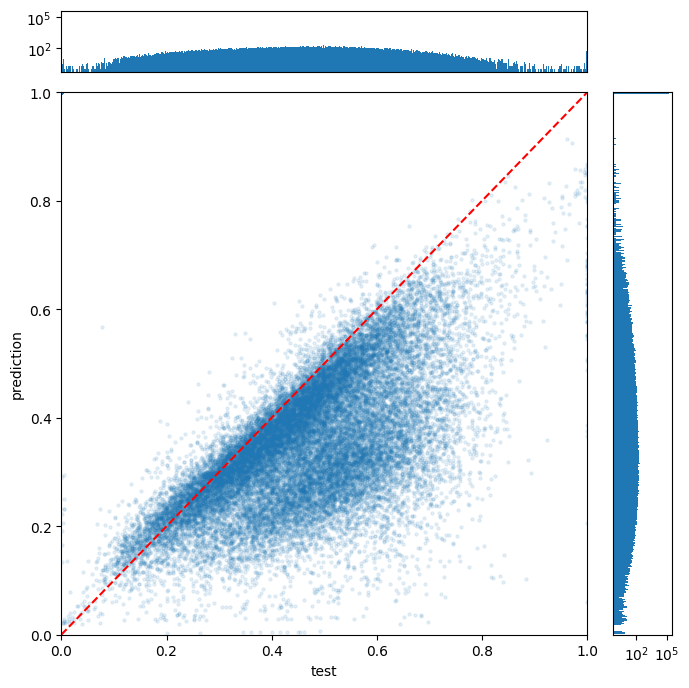

In [38]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(7,7),
    dpi=100,
    gridspec_kw={
        "height_ratios":[0.1,0.9],
        "width_ratios":[0.9,0.1]
                 }
)

values_test, bins_test = np.histogram(test, bins=np.linspace(test.min(), test.max(), 500))
ax[0,0].bar(
    x=bins_test[:-1],
    height=values_test,
    width=bins_test[1]-bins_test[0]
)
ax[0,0].set_xticks([])
ax[0,0].set_yscale("log")

ax[1,0].scatter(
    x=test.reshape(test.shape[0]*test.shape[-1]),
    y=pred.reshape(pred.shape[0]*pred.shape[-1]),
    s=5, alpha=0.1
)
ax[1,0].plot(
    [0,1],
    [0,1],
    linestyle="dashed",
    color="red"
)
ax[1,0].set_xlabel("test")
ax[1,0].set_ylabel("prediction")

values_pred, bins_pred = np.histogram(pred, bins=np.linspace(pred.min(), pred.max(), 500))
ax[1,1].barh(
    bins_pred[:-1],
    values_pred,
    height=bins_test[1]-bins_test[0]
)
ax[1,1].set_yticks([])
ax[1,1].set_xscale("log")

ax[0,1].set_axis_off()

ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[0,0].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
plt.tight_layout()
plt.show()

In [32]:
prm.WaTer()

Last updated: 2024-09-09T11:10:42.473428+02:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 116 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

